In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [3]:
class MoodCNN(nn.Module):
    def __init__(self, num_classes):
        super(MoodCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [4]:
train_dataset = datasets.ImageFolder("data/train", transform=transform)
test_dataset  = datasets.ImageFolder("data/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

model = MoodCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Accuracy: {acc:.4f}")

Epoch 1/30 - Loss: 4520.6883 - Accuracy: 0.4849
Epoch 2/30 - Loss: 3802.2128 - Accuracy: 0.5791
Epoch 3/30 - Loss: 3413.3234 - Accuracy: 0.6235
Epoch 4/30 - Loss: 3075.0303 - Accuracy: 0.6582
Epoch 5/30 - Loss: 2751.1184 - Accuracy: 0.6907
Epoch 6/30 - Loss: 2489.0953 - Accuracy: 0.7174
Epoch 7/30 - Loss: 2271.4996 - Accuracy: 0.7392
Epoch 8/30 - Loss: 2075.8719 - Accuracy: 0.7596
Epoch 9/30 - Loss: 1922.8029 - Accuracy: 0.7745
Epoch 10/30 - Loss: 1806.3965 - Accuracy: 0.7877
Epoch 11/30 - Loss: 1713.4147 - Accuracy: 0.7960
Epoch 12/30 - Loss: 1613.6305 - Accuracy: 0.8068
Epoch 13/30 - Loss: 1545.4475 - Accuracy: 0.8157
Epoch 14/30 - Loss: 1482.5454 - Accuracy: 0.8222
Epoch 15/30 - Loss: 1422.0992 - Accuracy: 0.8291
Epoch 16/30 - Loss: 1373.7113 - Accuracy: 0.8351
Epoch 17/30 - Loss: 1331.4553 - Accuracy: 0.8399
Epoch 18/30 - Loss: 1301.2962 - Accuracy: 0.8424
Epoch 19/30 - Loss: 1270.2766 - Accuracy: 0.8484
Epoch 20/30 - Loss: 1235.0179 - Accuracy: 0.8502
Epoch 21/30 - Loss: 1189.3235

In [6]:
torch.save(model.state_dict(), "models/model.pth")
print("✅ Training complete. Model saved.")

✅ Training complete. Model saved.


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"🧪 Test Loss: {total_loss:.4f}, Test Accuracy: {acc:.4f}")

evaluate_model(model, test_loader)

🧪 Test Loss: 2625.1135, Test Accuracy: 0.4900


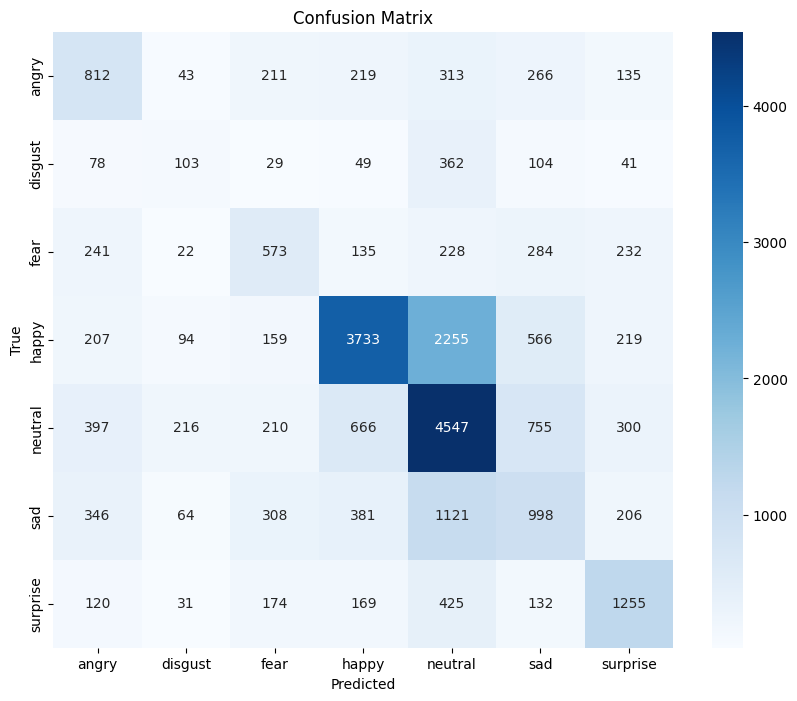

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader, train_dataset.classes)


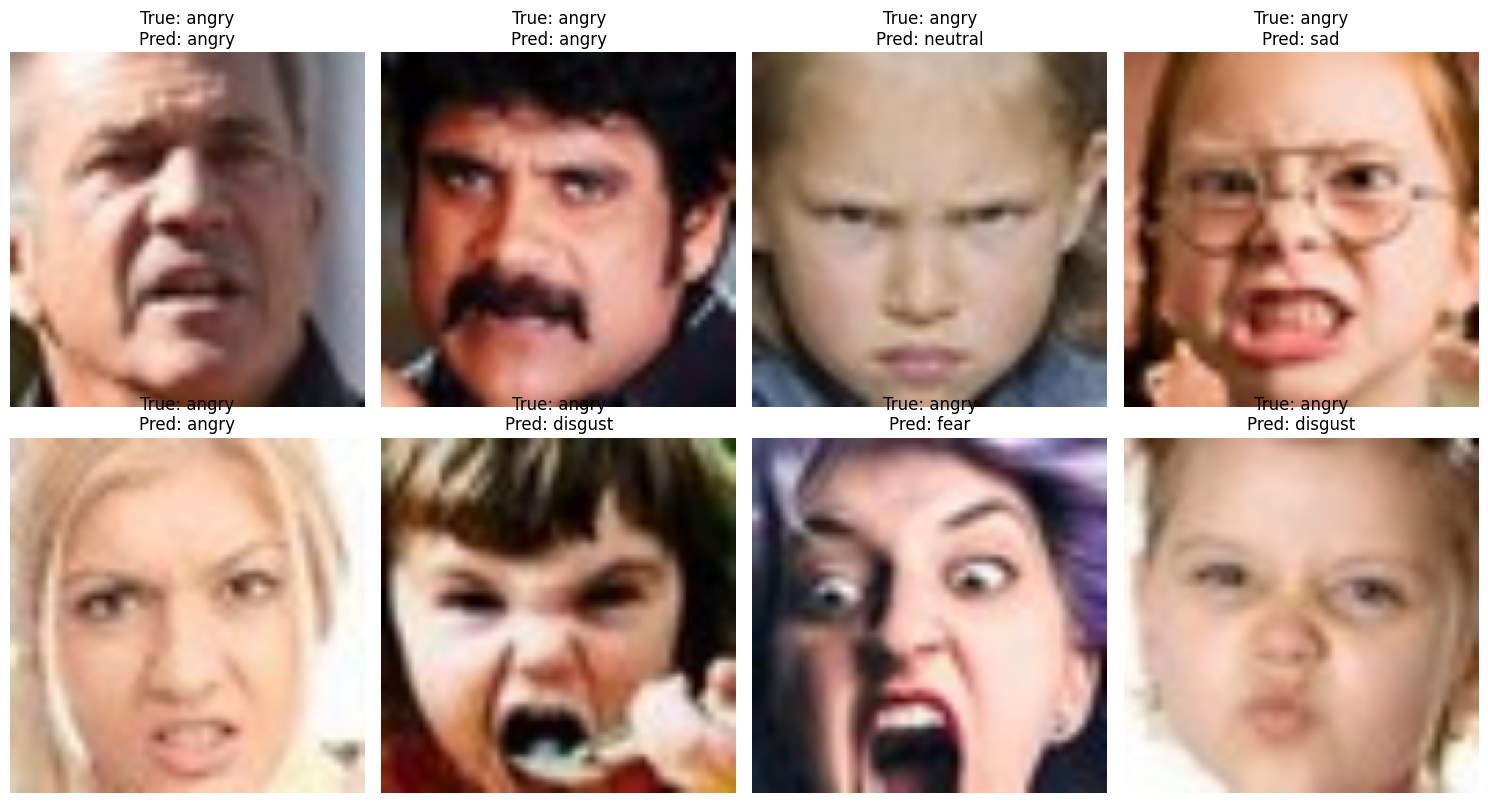

In [9]:
def visualize_predictions(model, test_loader, class_names, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    break
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = std * img + mean  # Unnormalize
                img = np.clip(img, 0, 1)

                plt.subplot(2, num_images // 2, images_shown + 1)
                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}")
                plt.axis("off")
                images_shown += 1

            if images_shown == num_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, train_dataset.classes)


/tmp/ipykernel_10909/2082029883.py:33: UserWarning: Mismatched number of handles and labels: len(handles) = 1 len(labels) = 7
  plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.classes)


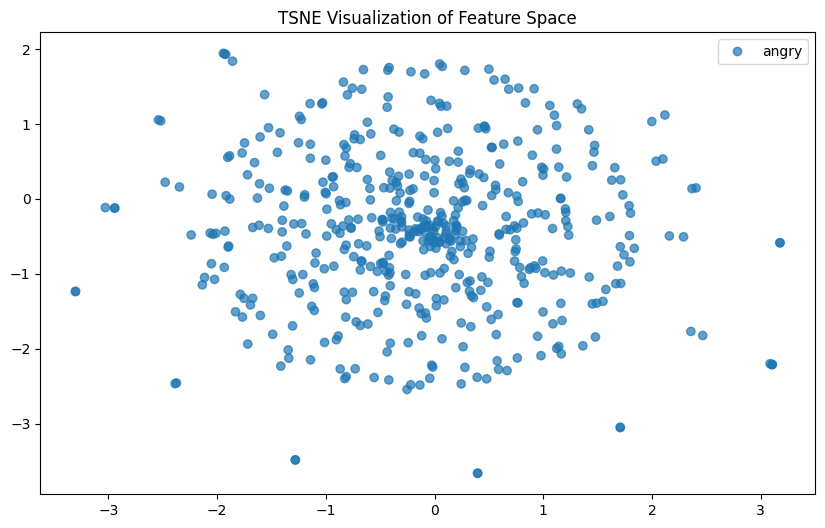

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_feature_space(model, loader, method='tsne', max_samples=500):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, lbls in loader:
            inputs = inputs.to(device)
            x = inputs
            for layer in model.network:
                x = layer(x)
                if isinstance(layer, nn.Flatten):
                    break
            features.append(x.view(x.size(0), -1).cpu())
            labels.extend(lbls.numpy())
            if len(labels) >= max_samples:
                break

    features = torch.cat(features)[:max_samples].numpy()
    labels = np.array(labels[:max_samples])

    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30)
    else:
        reducer = PCA(n_components=2)

    reduced = reducer.fit_transform(features)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=train_dataset.classes)
    plt.title(f'{method.upper()} Visualization of Feature Space')
    plt.show()

visualize_feature_space(model, test_loader, method='tsne')
